In [1]:
# Import all Libraries

import os
import re
import pandas as pd
from scipy.signal import get_window
import numpy as np
from tqdm import tqdm
import random
import enum
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from python_speech_features import mfcc,logfbank,ssc,delta,fbank
from python_speech_features.sigproc import powspec,framesig
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import soundfile as sf
import librosa as lb

import sys
sys.path.insert(1, '/content/drive/My Drive/Environmental')
import stft,dft

sns.set(style="darkgrid", color_codes=True)

In [2]:
path=os.getcwd()
dataset='\\ESC-10\\'
clean_path='\\Clean Files\\'
#path='/content/drive/My Drive/Environmental'
os.listdir(path+dataset)

['001 - Dog bark',
 '002 - Rain',
 '003 - Sea waves',
 '004 - Baby cry',
 '005 - Clock tick',
 '006 - Person sneeze',
 '007 - Helicopter',
 '008 - Chainsaw',
 '009 - Rooster',
 '010 - Fire crackling',
 'ESC-10-HumanClassification.xlsx',
 'ESC-10.png',
 'README.md',
 'README.txt']

### 1.1 Setting up the Audio Files

We have 400 files distributed among 10 classes. There is one folder for each class. To manage the files we put all the filenames and their corresponding labels in a dataframe.<br> 

In [3]:
# Create String Equivalents for each of the 10 labels

my_labels={1:'Dog',2:'Rain',3:'Waves',4:'Baby',
           5:'Clock',6:'Sneeze',7:'Helicopter',8:'Chainsaw',
           9:'Rooster',10:'Fire'}

# Make a List of all Input Audio Files

data_path=path+dataset
data_folders=[data_path+i for i in os.listdir(data_path) if os.path.isfile(data_path+i)==False]
audio_files=[]
labels=[]
for i in data_folders:
    [audio_files.append(i+'/'+k) for k in os.listdir(i)]
    [labels.append(int(re.findall('0\d\d',i)[0])) for k in os.listdir(i)]
    
# Create the dataframe with filenames and Labels
df=pd.DataFrame(list(zip(audio_files,labels)),columns=['Files','Labels'])
df['Class']=df['Labels'].apply(lambda x:my_labels[x])

In [4]:
df['Test_Val']=df['Files'].apply(lambda x:'Val' if x.split('/')[-1][0]=='5' else 'Test')
df.head()

,Files,Labels,Class,Test_Val
0,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,1,Dog,Test
1,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,1,Dog,Test
2,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,1,Dog,Test
3,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,1,Dog,Test
4,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,1,Dog,Test


At this stage the dataframe has the file names, Integer Labels and Class Names. We can randomly view a sample fro each class. The list __random_clips__ is made of 10 tuples. Each tuple has a class file and a label.

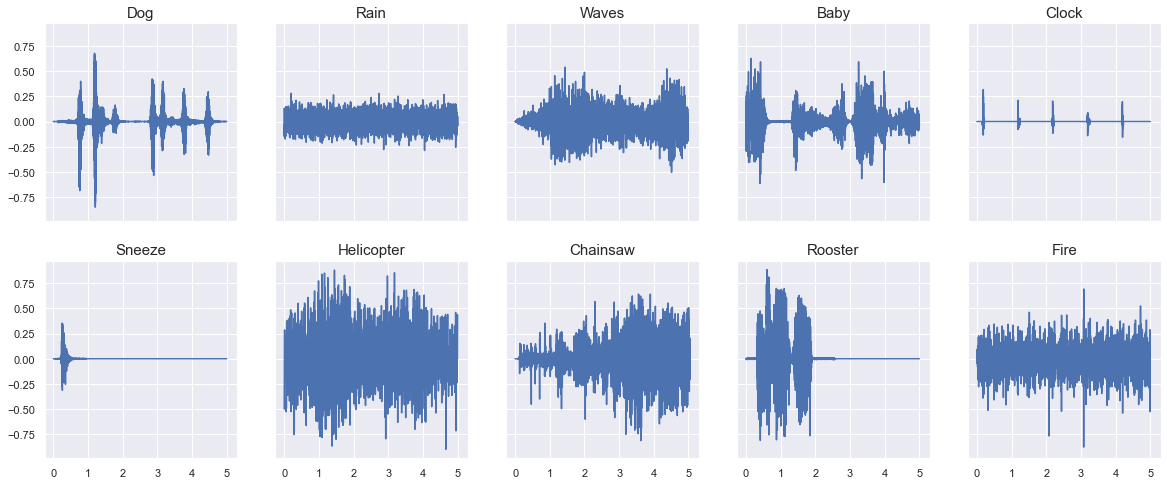

In [5]:
my_labels=df['Class'].unique()
random_clips=[]
for label in my_labels:
    sample_df=df[df['Class']==label].sample()
    random_clips.append((sample_df.iloc[0,0],label))
    

fig1, ax1= plt.subplots(2,5,figsize=(20,8),sharey=True,sharex=True)
clip=0

for ro in [0,1]:
    for col in [0,1,2,3,4]:
        signal, rate = lb.load(random_clips[clip][0],sr=44100)
        
        clip_duration=int(len(signal)/rate)
        clip_length=len(signal)
        
        ax1[ro,col].set_xticks(np.linspace(0,clip_length,clip_duration+1))
        ax1[ro,col].set_xticklabels(np.arange(clip_duration+1))
        
        ax1[ro,col].set_title(random_clips[clip][1],fontsize=15)
        sns.lineplot(x=np.arange(0,len(signal),50),y=signal[::50],ax=ax1[ro,col])
        clip+=1

## 1.2 Masking Silent Parts

The diversity in audio clips is immediately obvious. While some clips have information throughout the entire duration, some have practically none. A prominent example would be the __sneeze__ class.<br> We need to get rid of these silent parts,as they are useless in terms of informtion. We take the example of the __sneeze__ class and prepare a mask.

We use the pandas rolling function to calculate a rolling average of the signal over a moving window. The window size is one-tenth of the sample-rate. Thus we will have a sequence of means for every one-tenth of the clip. We can compare this mean against a threshold. 

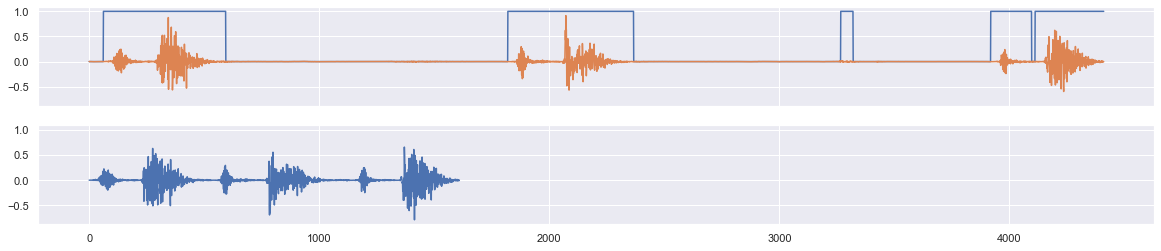

In [6]:
#one_sample='/content/drive/My Drive/Environmental/ESC-10/006 - Person sneeze/4-156844-A.ogg'
one_sample=path+'/ESC-10/006 - Person sneeze/4-156844-A.ogg'
signal, rate = lb.load(one_sample,sr=44100)
y=pd.Series(signal).apply(np.abs)
y_mean=y.rolling(window=int(rate/10),min_periods=1,center=True).mean()

mask=[]
for mean in y_mean:
        if mean>0.003:
            mask.append(1)
        else:
            mask.append(0)

masked_signal=mask*signal
masked_signal=masked_signal[masked_signal!=0]

fig2, ax2= plt.subplots(2,1,figsize=(20,4),sharey=True,sharex=True)
sns.lineplot(x=np.arange(0,len(mask[::50])),y=mask[::50],ax=ax2[0])
sns.lineplot(x=np.arange(0,len(signal[::50])),y=signal[::50],ax=ax2[0])

sns.lineplot(x=np.arange(0,len(masked_signal[::50])),y=masked_signal[::50],ax=ax2[1])


## 1.3 Setting up Pre-processing Hyperparameters

- Segment Size __20ms__
- Segment Size in Samples __M__ and __Ms__ in mili-seconds
- Sample rate __44100Hz__
- Hop Size in sample __H__ and __Hs__ in miliseconds


In [7]:
# Pre processing Hyper-parameters

sample_rate=44100                                           # Sample Rate
Ms=25/1000                                                  # Segment size , in milli-seconds in numerator
M=int(Ms*sample_rate)                                       # Size of the segment in samples

Hs=Ms/2                                                     # Hop size in mili-second
H=M//2                                                      # Hop-length in samples
N=1024                                                      # FFT Size
w=get_window('hanning',M)                                   # Choose Window

## 1.4 Cleaning the Clips

We can see that some of the audio clips have plenty of silence periods. Especially the __Sneeze__ class, has a momentary presence of data , then all goes quite. We need to clean these clips , so that the silence periods are removed.

__Execute only for removal of the Clean Files__

In [8]:
clean_files=[path+clean_path+'\\'+i for i in os.listdir(path+clean_path)]
for i in clean_files:
    os.remove(i)

In [9]:
def envelop(y,rate,threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean=y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

def clean_file(row):
    filename=row['Files'].split('/')[-1]
    #filename=re.split('/',row['Files'])[-1]
    signal, rate = sf.read(row['Files'])
    
    # Choose appropriate Threshold Here 
    if row['Test_Val']=='Test':
        mask=envelop(signal,rate,0.003)
    else:
        mask=envelop(signal,rate,0.03)
    
    signal=signal[mask]
    sf.write(path+clean_path+filename, signal, rate)
        
    return filename

def clean_file_name(row):
    filename=row['Files'].split('/')[-1]
    return filename

def clean_file_duration(row):
    
    clean_file=path+clean_path+row['Clean File']
    signal, rate = sf.read(clean_file)
    
    return (len(signal)/rate)
                                

In [10]:
#clean_path=path+'/Clean Files'
if len(os.listdir(path+clean_path))==0:
    df['Clean File']=df.apply(clean_file,axis=1)
    #df['Test_Val']=df['Clean File'].apply(lambda x:'Val' if x[0]=='5' else 'Test')
    #zip(*df_test['size'].apply(sizes))
else:
    df['Clean File']=df['Files'].apply(lambda x:re.split('/',x)[-1])

In [11]:
df['Duration']=df.apply(clean_file_duration,axis=1)
df['Labels']=df['Labels'].apply(lambda x:x-1)
df=df[df['Duration']>0.2]
df

,Files,Labels,Class,Test_Val,Clean File,Duration
0,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-100032-A.ogg,0.330227
1,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-110389-A.ogg,0.407755
2,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-30226-A.ogg,4.791837
3,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-30344-A.ogg,2.749773
4,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-32318-A.ogg,3.281179
...,...,...,...,...,...,...
392,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-186924-A.ogg,5.000998
393,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-189212-A.ogg,3.157256
397,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-213802-A.ogg,5.000998
398,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-215658-A.ogg,2.571655


We can now visualize the cleaned version of the audio clips, with silent periods removed.

In [12]:
random_clips_cleaned=[]

for file in random_clips:
    orig_file=file[0]
    label=file[1]
    
    if df[df['Files']==orig_file].shape[0]!=0:
        clean_file_name=df[df['Files']==orig_file]['Clean File'].tolist()[0]
        clean_file=path+clean_path+clean_file_name
    else:
        clean_file='File Removed'
    random_clips_cleaned.append((clean_file,label))

In [13]:
random_clips_cleaned

[('C:\\Users\\Arindam\\Documents\\Up_Grad\\Research\\Clean Files\\4-192236-A.ogg',
  'Dog'),
 ('C:\\Users\\Arindam\\Documents\\Up_Grad\\Research\\Clean Files\\3-157149-A.ogg',
  'Rain'),
 ('C:\\Users\\Arindam\\Documents\\Up_Grad\\Research\\Clean Files\\5-208810-A.ogg',
  'Waves'),
 ('C:\\Users\\Arindam\\Documents\\Up_Grad\\Research\\Clean Files\\4-185575-B.ogg',
  'Baby'),
 ('C:\\Users\\Arindam\\Documents\\Up_Grad\\Research\\Clean Files\\4-188033-A.ogg',
  'Clock'),
 ('C:\\Users\\Arindam\\Documents\\Up_Grad\\Research\\Clean Files\\1-31748-A.ogg',
  'Sneeze'),
 ('C:\\Users\\Arindam\\Documents\\Up_Grad\\Research\\Clean Files\\5-177957-B.ogg',
  'Helicopter'),
 ('C:\\Users\\Arindam\\Documents\\Up_Grad\\Research\\Clean Files\\2-77945-A.ogg',
  'Chainsaw'),
 ('C:\\Users\\Arindam\\Documents\\Up_Grad\\Research\\Clean Files\\5-233160-A.ogg',
  'Rooster'),
 ('C:\\Users\\Arindam\\Documents\\Up_Grad\\Research\\Clean Files\\5-215658-B.ogg',
  'Fire')]

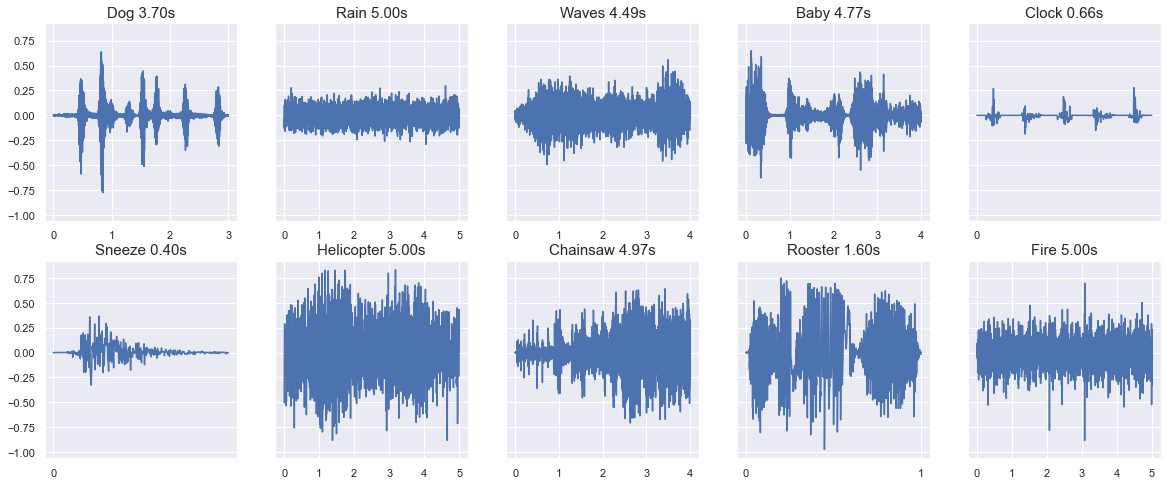

In [14]:
fig3, ax3= plt.subplots(2,5,figsize=(20,8),sharey=True)
clip=0

for ro in [0,1]:
    for col in [0,1,2,3,4]:
        if  random_clips_cleaned[clip][0]!='File Removed':
            signal, rate = sf.read(random_clips_cleaned[clip][0])

            clip_duration=int(len(signal)/rate)
            clip_length=len(signal)
            #print(len(signal)/rate)        
            ax3[ro,col].set_xticks(np.linspace(0,clip_length,clip_duration+1))
            ax3[ro,col].set_xticklabels(np.arange(clip_duration+1))

            ax3[ro,col].set_title(random_clips[clip][1]+' '+str('{:0.2f}'.format(len(signal)/rate))+'s',fontsize=15)
            sns.lineplot(x=np.arange(0,len(signal),50),y=signal[::50],ax=ax3[ro,col])
            clip+=1
        else:
            ax3[ro,col].set_title('File Too Small',fontsize=15)
            clip+=1

One problem we immediately notice that the clips with prolonged silent periods are shortened. This explains the unequal clip-length after cleaning the audio clips.

In [15]:
df.to_csv(path+'\\Cleaned data low threshold.csv')

# 1.3 Visualizing the Data

We now visualize this audio clips by using STFT __( Short Term Fourier Transform )__. Despite the unequal clip durations, we break each clip into frames, called segments.<br>

The list __random_clips_cleaned__ has 1 file each from each class picked randomly. We apply these pre-processing parameters to calculate the STFT of each these clips. The number of available segments is shown at the top of each sub-plot.

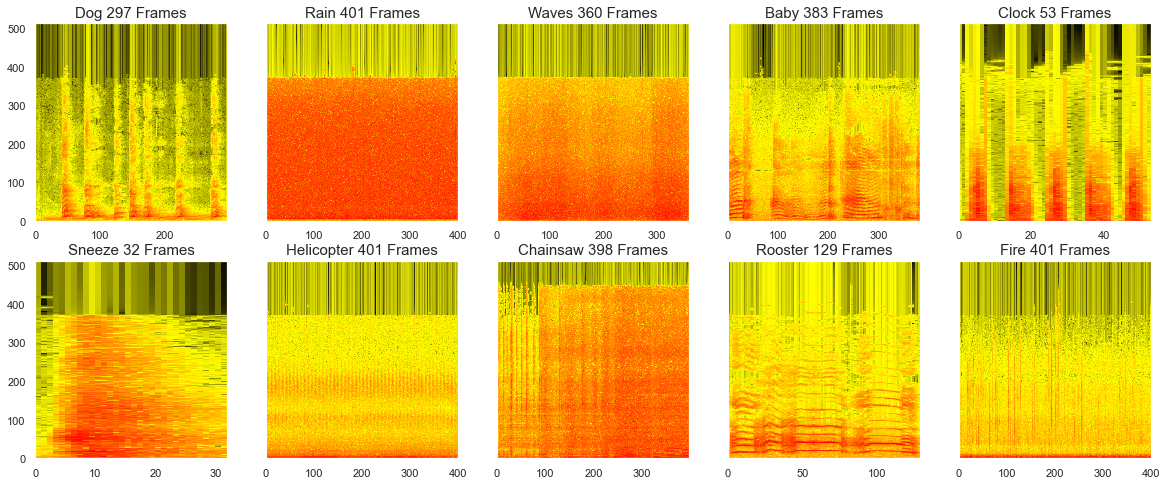

In [16]:
fig4, ax4= plt.subplots(2,5,figsize=(20,8),sharey=True)

clip=0

cvals  = [-1, 0, 1]
colors = ["black","yellow","red"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

for ro in [0,1]:
    for col in [0,1,2,3,4]:
        if  random_clips_cleaned[clip][0]!='File Removed':
            signal, samplerate = sf.read(random_clips_cleaned[clip][0])
            clip_duration=int(len(signal)/samplerate)
            clip_length=len(signal)
            mX,pX,n=stft.stftAnal(signal,w,N,H)

            num_frames=len(mX)

            ax4[ro,col].set_title(random_clips[clip][1]+' '+str(num_frames)+' Frames',fontsize=15)
            ax4[ro,col].pcolormesh(mX.T,cmap=cmap)

            clip+=1
        else:
            ax4[ro,col].set_title('File Too Small',fontsize=15)
            clip+=1

# 1.5 MFCC from STFT

Each STFT segment that we calculated from segments of size Ms mili-seconds, will be converted to MFCCs. 

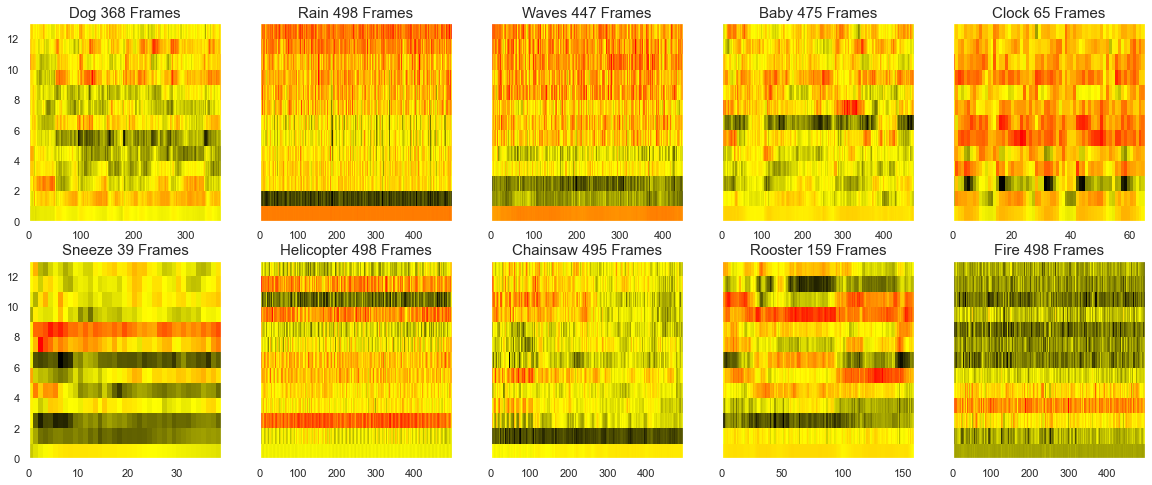

In [17]:
fig4, ax4= plt.subplots(2,5,figsize=(20,8),sharey=True)

clip=0

cvals  = [-50, 0, 50]
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

for ro in [0,1]:
    for col in [0,1,2,3,4]:
        if  random_clips_cleaned[clip][0]!='File Removed':
        
            signal, samplerate = lb.load(random_clips_cleaned[clip][0],sr=22050)

            clip_duration=int(len(signal)/samplerate)
            clip_length=len(signal)

            mel=mfcc(signal,samplerate,winlen=0.025,winstep=0.01,nfilt=26,nfft=1024).T
            num_frames=mel.shape[1]

            ax4[ro,col].pcolormesh(mel,cmap=cmap)
            ax4[ro,col].set_title(random_clips[clip][1]+' '+str(num_frames)+' Frames',fontsize=15)
            clip+=1
        else:
            ax4[ro,col].set_title('File Too Small',fontsize=15)
            clip+=1

# 2.1 Generate the Dataset

We noticed that after cleaning the audio files, we lost quite a bit of the clips , specifically for samples that are bursty in nature ( e.g. sneeze, dog-bark ). This means the dataset has become imbalanced. When we draw samples from the audio files, we need to make sure that they are drawn following a probability distribution based on the total duration of the each class.  

In [18]:
train_set=df[df['Test_Val']=='Test']
train_set.reset_index(inplace=True)
train_set=train_set.drop('index',axis=1)

val_set=df[df['Test_Val']=='Val']
val_set.reset_index(inplace=True)
val_set=val_set.drop('index',axis=1)

Text(0.5, 1.0, 'Duration of Validation Set Classes')

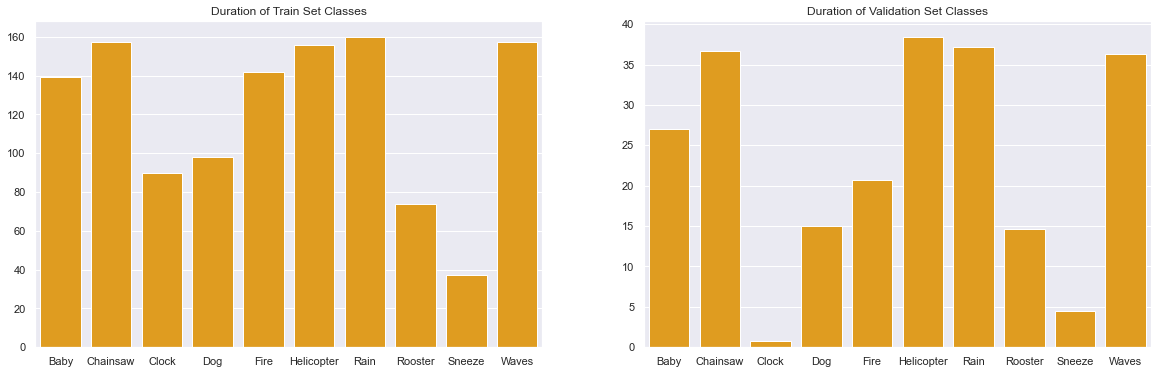

In [19]:
fig5, ax5= plt.subplots(1,2,figsize=(20,6),sharey=False,sharex=False)

x=list(train_set.groupby('Class')['Duration'].sum().index)
y=list(train_set.groupby('Class')['Duration'].sum())
sns.barplot(x=x, y=y,color='orange',ax=ax5[0])
ax5[0].set_title("Duration of Train Set Classes")

x=list(val_set.groupby('Class')['Duration'].sum().index)
y=list(val_set.groupby('Class')['Duration'].sum())
sns.barplot(x=x, y=y,color='orange',ax=ax5[1])
ax5[1].set_title("Duration of Validation Set Classes")

In [20]:
train_set

,Files,Labels,Class,Test_Val,Clean File,Duration
0,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-100032-A.ogg,0.330227
1,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-110389-A.ogg,0.407755
2,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-30226-A.ogg,4.791837
3,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-30344-A.ogg,2.749773
4,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-32318-A.ogg,3.281179
...,...,...,...,...,...,...
315,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Test,4-170247-B.ogg,5.000998
316,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Test,4-171207-A.ogg,5.000998
317,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Test,4-181563-A.ogg,5.000998
318,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Test,4-182368-A.ogg,5.000998


In [21]:
train_samples=int(2*train_set['Duration'].sum()/0.1)
val_samples=int(2*val_set['Duration'].sum()/0.1)

In [22]:
print("Number of Train Samples",train_samples)
print("Number of Train Samples",val_samples)

Number of Train Samples 24212
Number of Train Samples 4624


In [23]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second

In [24]:
train_data=[]
val_data=[]

for idx in train_set.index:
    clip=lb.load(path+clean_path+'/'+train_set.at[idx,'Clean File'],sr=16000)[0]
    clip = clip / np.max(np.abs(clip))
    train_data.append(clip)
    
for idx in val_set.index:
    clip=lb.load(path+clean_path+'/'+val_set.at[idx,'Clean File'],sr=16000)[0]
    clip = clip / np.max(np.abs(clip))
    #clip=(clip-clip.min())/(clip.max()-clip.min())
    val_data.append(clip)
winsound.Beep(frequency, duration)

In [25]:
# MFCC Hyper-parameters
my_rate=16000                                               # Sample Rate
Ms=25/1000                                                  # Segment size , in milli-seconds in numerator
M=int(Ms*my_rate)                                           # Size of the segment in samples

Hs=10/1000                                                  # Hop size in mili-second
H=M//2                                                      # Hop-length in samples
N=512                                                       # FFT Size

In [27]:
Hs

0.01

In [28]:
X=[]
y=[]

for i in tqdm(range(0,train_samples)):
#for i in tqdm(range(0,2)):
    id=train_set.sample().index[0]

    signal= train_data[id]
    random_sample=np.random.randint(0,signal.shape[0]-1600)

    mel=mfcc(signal[random_sample:random_sample+1600],my_rate,winlen=Ms,numcep=13,
             winstep=Hs,nfilt=26,nfft=512,winfunc=np.hamming)
    #filter_banks, energies = fbank(signal[random_sample:random_sample+4410],
                                   #samplerate=my_rate, nfilt=26, winlen=Ms)
    del_1=delta(mel,2)
    #el_2=delta(del_1,1)
    j=np.zeros([13,9,2])
    j[::,::,0]=mel.T
    j[::,::,1]=del_1.T
    #j[::,::,2]=del_2.T
    
    label=[train_set.at[id,'Labels']][0]
    
    X.append(j)
    y.append(label)

y_train=np.zeros([train_samples,10])
y_train[np.arange(np.array(y).size),np.array(y)]=1
X_train=np.array(X)

100%|███████████████████████████████████████████████████████████████████████████| 24212/24212 [01:32<00:00, 260.69it/s]


In [29]:
mel.shape

(9, 13)

In [30]:
val_set=val_set.sample(frac = 1)
val_set.index

Int64Index([50,  6, 46, 67, 52, 21,  3, 43, 38, 54, 49, 68, 33, 28,  8, 53, 32,
            51, 36, 15, 26, 63, 66, 29, 60, 14, 62, 13, 22, 11, 18, 55, 65, 44,
            69, 58,  4, 25, 30, 10, 42, 47, 59, 16, 27,  5, 57, 20, 64, 40,  7,
            24, 19, 61, 41,  9, 31, 35,  0, 39, 48, 56, 34, 12, 17, 37,  1,  2,
            45, 70, 23],
           dtype='int64')

In [31]:
val_set.shape

(71, 6)

In [32]:
X=[]
y=[]

for id in tqdm(val_set.index):
    
    signal=val_data[id]
    random_sample=0
    
    mel=mfcc(signal[random_sample:random_sample+1600],my_rate,winlen=Ms,numcep=13,
             winstep=Hs,nfilt=26,nfft=512,winfunc=np.hamming)
    #filter_banks, energies = fbank(signal[random_sample:random_sample+4410],
                                   #samplerate=my_rate, nfilt=26, winlen=Ms)
    del_1=delta(mel,2)
    #del_2=delta(del_1,1)
    
    j=np.zeros([13,9,2])
    j[::,::,0]=mel.T
    j[::,::,1]=del_1.T
    #j[::,::,2]=del_2.T
    
    label=[val_set.at[id,'Labels']][0]
    X.append(j)
    y.append(label)

y_val=np.zeros([71,10])
y_val[np.arange(np.array(y).size),np.array(y)]=1
X_val=np.array(X)

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 450.57it/s]


In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(24212, 13, 9, 2)
(24212, 10)
(71, 13, 9, 2)
(71, 10)


In [34]:
X_min = X_train.min(axis=(0,1,2), keepdims=True)
X_max = X_train.max(axis=(0,1,2), keepdims=True)

In [35]:
X_train_scaled=(X_train-X_min)/(X_max-X_min)
X_val_scaled=(X_val-X_min)/(X_max-X_min)

np.savez_compressed('Training Data w Delta2.npz',name1=X_train_scaled,name2=y_train)
np.savez_compressed('Validation Data w Delta2.npz',name1=X_val_scaled,name2=y_val)